<a href="https://colab.research.google.com/github/dailyLi/yelp_da/blob/main/Yelp_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Sentiment Analysis with Yelp Review Data Set

As one of the most popular local business information app in North America, Yelp is widely used for review and rating. User reviews can bring insight for business owners for service improvement, and help potential customers find their choice of dining, shopping and other local services. 

Therefore, the objective of this project is to identify the polarity (positive or negative) of Yelp reviews using machine learning techniques, specifically, NLP sentiment analysis with Keras. The project would mainly focus on enhancing customers’ understanding of restaurants, educating new business owners on market knowledge, and improving existing merchants’ awareness about their performance. 

## Data set

The Yelp reviews dataset consists of reviews from Yelp Dataset Challenge 2015 data. The Yelp reviews polarity dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) and retrieved from https://course.fast.ai/datasets.

The Yelp reviews polarity dataset is constructed by considering stars 1 and 2 negative, and 3 and 4 positive. For each polarity 280,000 training samples and 19,000 testing samples are take randomly. In total there are 560,000 trainig samples and 38,000 testing samples. Negative polarity is class 1, and positive class 2.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 2 columns in them, corresponding to class index (1 and 2) and review text. The review texts are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf 
from tensorflow.keras.preprocessing.text import Tokenizer

#from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from datetime import datetime

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/Yelp_sentiment/train.csv', names= ('class','text'))
test = pd.read_csv('drive/My Drive/Colab Notebooks/Yelp_sentiment/test.csv', names= ('class','text'))

In [5]:
train

,class,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


In [6]:
train.loc[train["class"] == 1, "class"] = 0
train.loc[train["class"] == 2, "class"] = 1
test.loc[test["class"] == 1, "class"] = 0
test.loc[test["class"] == 2, "class"] = 1

Take a brief look at how many words in each review by counting spaces in the text.

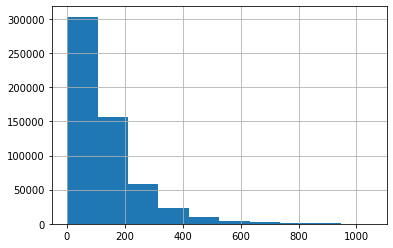

In [7]:
train["word_count"] = train["text"].str.split().str.len()
train["word_count"].hist()

In [8]:
X_train = train['text']
y_train = train['class']
X_test = test['text']
y_test = test['class']

Tokenize the text in training and testing data: choose the 20,000 most common words and set vector size as 300.

In [9]:
max_vocab = 20000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=300)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=300)

## Convolutional Neural Networks (CNN)

Build model and add layers:

- Embedding layer: represent words by dense vectors where a vector represents the projection of the word into a continuous vector space.

- Dropout: regularize the model to avoid overfitting by excluding 50% of the neurons from activation and weight updates while training. 

- Conv1D: the core building block of a CNN, and the layer where the majority of computation occurs. It creates a filter that calculates a higher-lever representation of the data, feeding the next layers with chunks instead of words. 

- MaxPooling1D: extract higher-level representation of the data, indicating more information will be expressed by max pooling.

- LSTM: learn sequences of data in the context. 

- Dense: change the dimension and generate final result.

In [10]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128, input_length=300),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          2560000   
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 296, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

### Train model

Since the data set contains 560,000 rows, so we run 3 epochs maximum, with batch size of 100, and use early stop that automatically stops training when a monitored metric "val_loss" has stopped improving. 

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train, y_train, epochs=3, validation_split=0.3, batch_size=100, shuffle=True, callbacks=[early_stop])

Epoch 1/3
3920/3920 [==============================] - 1877s 478ms/step - loss: 0.1972 - accuracy: 0.9195 - val_loss: 0.1233 - val_accuracy: 0.9556
Epoch 2/3
3920/3920 [==============================] - 1870s 477ms/step - loss: 0.1252 - accuracy: 0.9533 - val_loss: 0.1107 - val_accuracy: 0.9590
Epoch 3/3
3920/3920 [==============================] - 1879s 479ms/step - loss: 0.1047 - accuracy: 0.9609 - val_loss: 0.1118 - val_accuracy: 0.9597


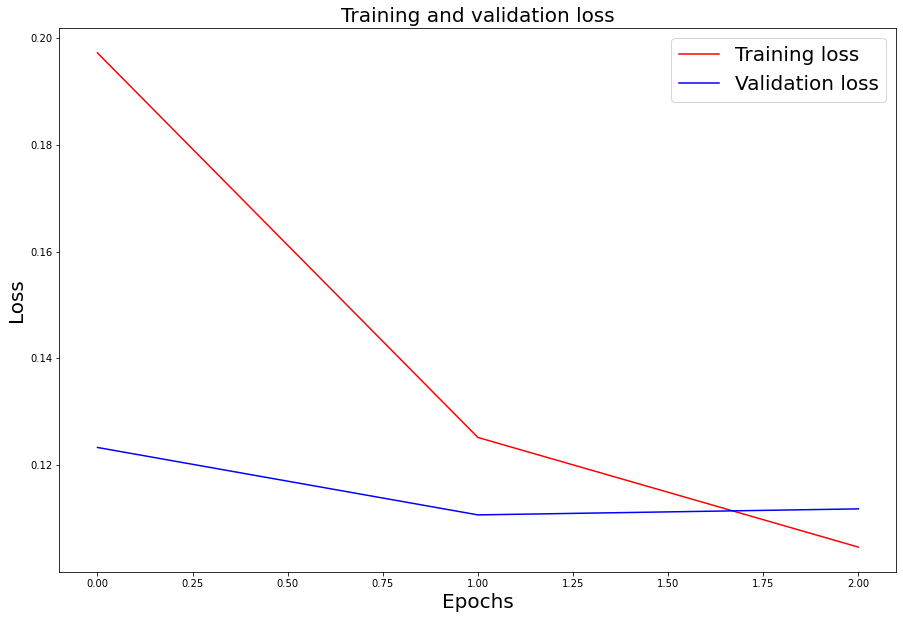

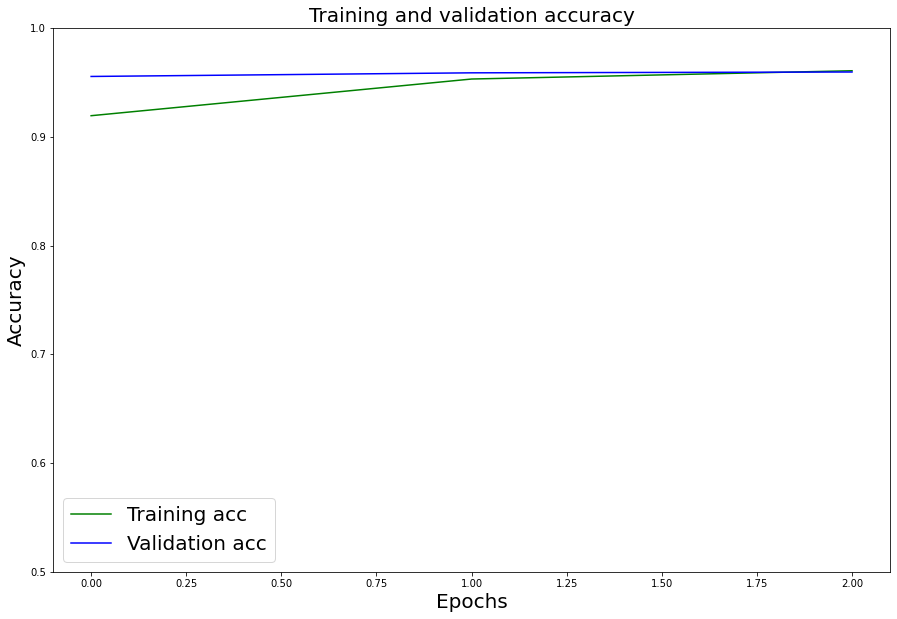

In [20]:
history_cnn_dict = history_cnn.history

acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']
epochs_cnn = history_cnn.epoch

plt.figure(figsize=(15,10))
plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs_cnn, acc_cnn, 'g', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.show()

### Evaluation

In [13]:
model_cnn.evaluate(X_test, y_test)

1188/1188 [==============================] - 49s 40ms/step - loss: 0.1183 - accuracy: 0.9571


[0.11831604689359665, 0.957105278968811]

In [22]:
pred_cnn = model_cnn.predict(X_test)

predictions_cnn = []

for i in pred_cnn:
    if i >= 0.5:
        predictions_cnn.append(1)
    else:
        predictions_cnn.append(0)

print('Accuracy on testing set:', accuracy_score(predictions_cnn, y_test))
print('Precision on testing set:', precision_score(predictions_cnn, y_test))
print('Recall on testing set:', recall_score(predictions_cnn, y_test))

Accuracy on testing set: 0.9571052631578948
Precision on testing set: 0.9568421052631579
Recall on testing set: 0.957345971563981


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

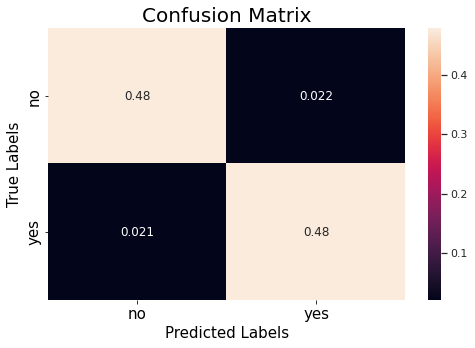

In [23]:
matrix = confusion_matrix(predictions_cnn, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["no","yes"], size=15)
ax.yaxis.set_ticklabels(["no","yes"], size=15)

## Recurrent Neural Networks (RNN)

### Build model and add layers

- Embedding layer: represent words by dense vectors where a vector represents the projection of the word into a continuous vector space.

- Bidirectional layers: enable straight (past) and reverse (future) traversal of input words so that LSTM can use context when predicting the next sample.

- Dense: change the dimension of the preceding bidirectional layer so that the model can define the relationship between the values of the data.

- Dropout: regularize the model by excluding 50% of the neurons from activation and weight updates while training a network. The purpose is to reduce overfitting and improve model performance.

- Dense: again change the dimension and generate final result.

The rest of the workflow is similar with that of CNN.


In [17]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          640000    
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        49664     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

### Train model
3 epochs maximum, with batch size of 200, and use early stop that automatically stops training when a monitored metric "val_loss" has stopped improving.

In [18]:
#model_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train, y_train, epochs = 3, validation_split=0.3, batch_size=200, shuffle=True, callbacks=[early_stop])

Epoch 1/3
1960/1960 [==============================] - 2987s 2s/step - loss: 0.5583 - accuracy: 0.7368 - val_loss: 0.4801 - val_accuracy: 0.9053
Epoch 2/3
1960/1960 [==============================] - 2977s 2s/step - loss: 0.4232 - accuracy: 0.8283 - val_loss: 0.8129 - val_accuracy: 0.4726
Epoch 3/3
1960/1960 [==============================] - 2999s 2s/step - loss: 0.5925 - accuracy: 0.6953 - val_loss: 0.5563 - val_accuracy: 0.7646


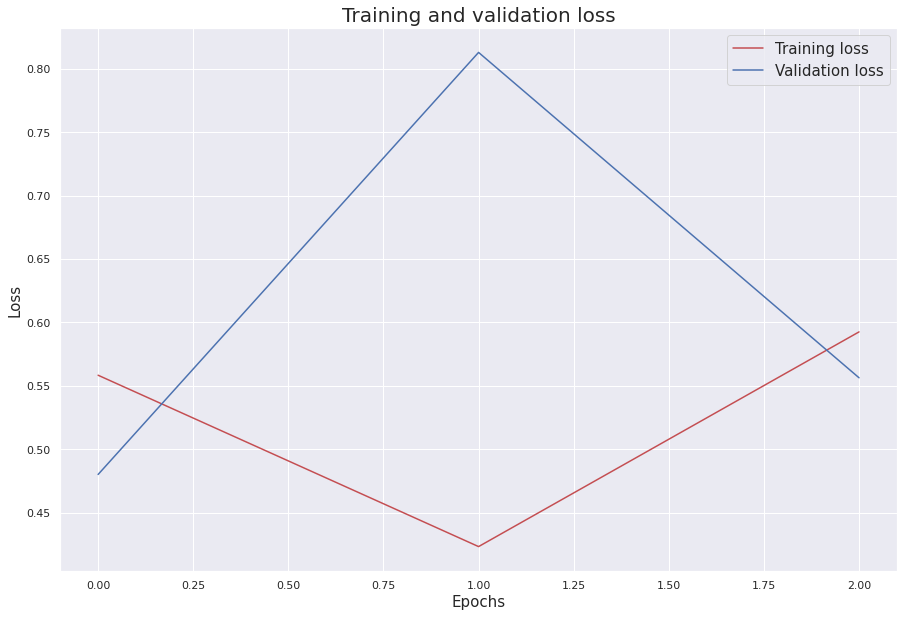

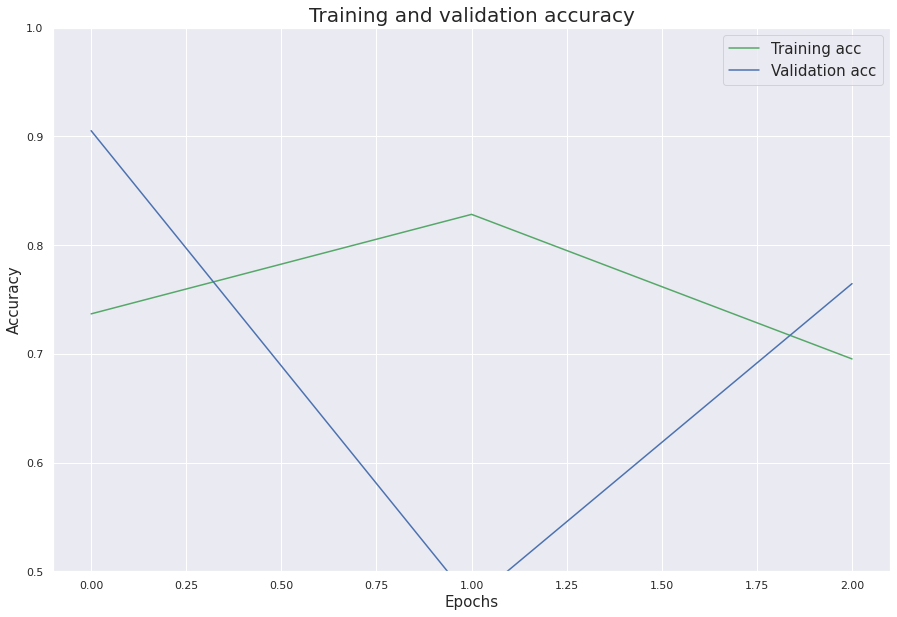

In [27]:
history_rnn_dict = history_rnn.history

acc_rnn = history_rnn_dict['accuracy']
val_acc_rnn = history_rnn_dict['val_accuracy']
loss_rnn = history_rnn_dict['loss']
val_loss_rnn = history_rnn_dict['val_loss']
epochs_rnn = history_rnn.epoch

plt.figure(figsize=(15,10))
plt.plot(epochs_rnn, loss_rnn, 'r', label='Training loss')
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=15)
plt.ylabel('Loss', size=15)
plt.legend(prop={'size': 15})
plt.show()

plt.figure(figsize=(15,10))
plt.plot(epochs_rnn, acc_rnn, 'g', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=15)
plt.ylabel('Accuracy', size=15)
plt.legend(prop={'size': 15})
plt.ylim((0.5,1))
plt.show()

### Evaluation

In [25]:
model_rnn.evaluate(X_test, y_test)

1188/1188 [==============================] - 131s 109ms/step - loss: 0.4892 - accuracy: 0.8982


[0.48919248580932617, 0.898236870765686]

In [26]:
pred_rnn = model_rnn.predict(X_test)

predictions_rnn = []

for i in pred_rnn:
    if i >= 0.5:
        predictions_rnn.append(1)
    else:
        predictions_rnn.append(0)

print('Accuracy on testing set:', accuracy_score(predictions_rnn, y_test))
print('Precision on testing set:', precision_score(predictions_rnn, y_test))
print('Recall on testing set:', recall_score(predictions_rnn, y_test))

Accuracy on testing set: 0.8982368421052631
Precision on testing set: 0.9147894736842105
Recall on testing set: 0.8854755718579652


[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

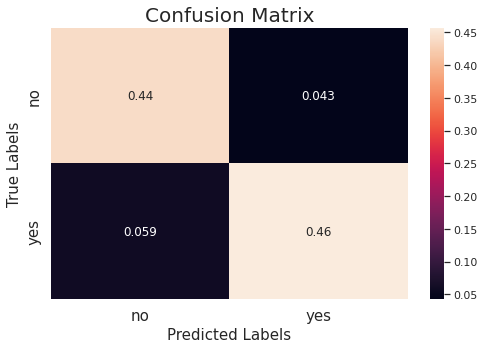

In [28]:
matrix = confusion_matrix(predictions_rnn, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["no","yes"], size=15)
ax.yaxis.set_ticklabels(["no","yes"], size=15)

## Support Vector Machines (SVM)



In [29]:
svc_texts = []
svc_labels = []

for i in range(len(X_train)):
    svc_texts.append(train['text'][i])
    svc_labels.append(train['class'][i])

data preproccsing and fit Support Vector Machine

In [41]:
t1 = datetime.now()
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
svc_classifier = LinearSVC(max_iter=5000)
Xs = vectorizer.fit_transform(svc_texts)
 
print(datetime.now() - t1)
print(Xs.shape)
 
score = cross_val_score(svc_classifier, Xs,svc_labels, cv=2, n_jobs=-1)

print(datetime.now() - t1)
print(score)
print(sum(score) / len(score))
svc_classifier.fit(Xs, np.array(svc_labels))

0:03:17.699953
(560000, 1563653)
0:04:08.380388
[0.94867857 0.95306786]
0.9508732142857144


LinearSVC(max_iter=5000)

In [42]:
svc_classifier.fit(X_train, y_train)
svc_pred = svc_classifier.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### Evaluation

In [39]:
print("Report for Support Vector Machine:")
print(classification_report(y_test, svc_pred))


Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50     19000
           1       0.51      0.54      0.53     19000

    accuracy                           0.52     38000
   macro avg       0.52      0.52      0.51     38000
weighted avg       0.52      0.52      0.51     38000



draw ROC curve

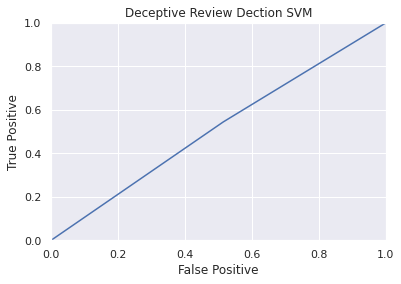

In [40]:
fpr, tpr, thresholds = roc_curve(y_test,svc_pred)

plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title("Deceptive Review Dection SVM")
plt.xlabel("False Positive")
plt.ylabel("True Positive")

plt.grid(True)
plt.show()

[Text(0, 0.5, 'no'), Text(0, 1.5, 'yes')]

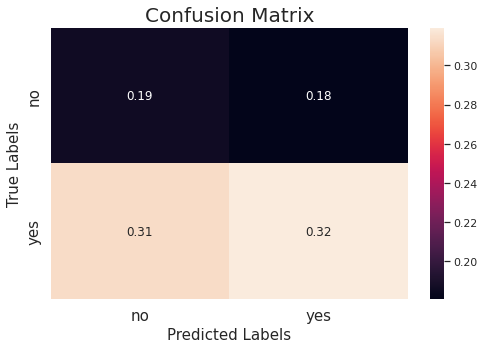

In [35]:
matrix = confusion_matrix(svc_pred, y_test, normalize='all')
plt.figure(figsize=(8, 5))
ax= plt.subplot()
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, ax = ax)

ax.set_xlabel('Predicted Labels', size=15)
ax.set_ylabel('True Labels', size=15)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(["no","yes"], size=15)
ax.yaxis.set_ticklabels(["no","yes"], size=15)